## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the Dataset

In [2]:
BASE_DIR = 'datafolder/UTKFace/'

In [3]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,datafolder/UTKFace/100_0_0_20170112213500903.j...,100,0
1,datafolder/UTKFace/100_0_0_20170112215240346.j...,100,0
2,datafolder/UTKFace/100_1_0_20170110183726390.j...,100,1
3,datafolder/UTKFace/100_1_0_20170112213001988.j...,100,1
4,datafolder/UTKFace/100_1_0_20170112213303693.j...,100,1


In [5]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

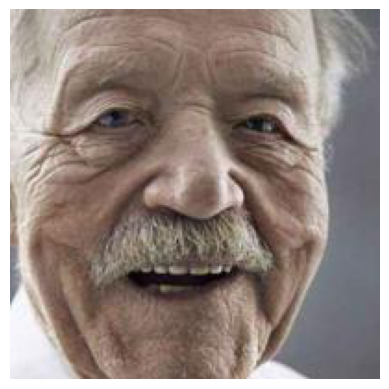

In [6]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

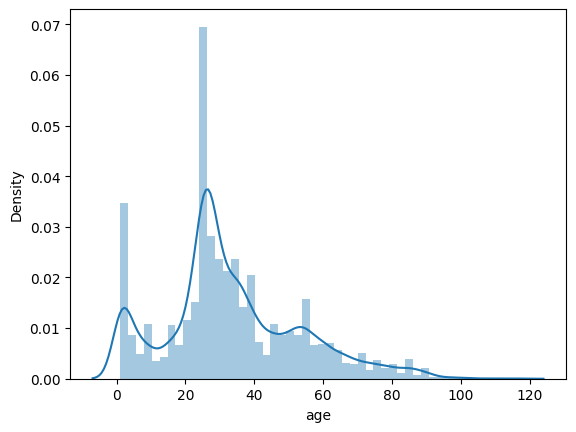

In [7]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

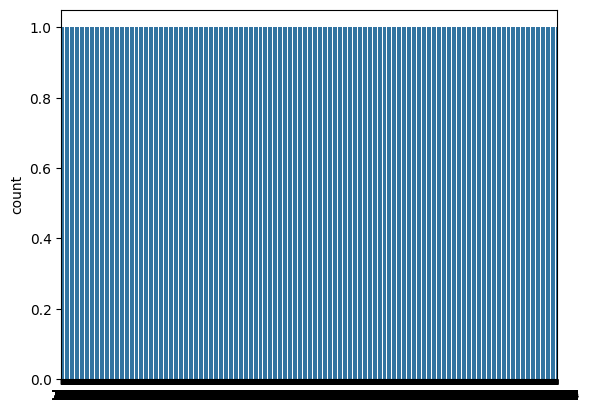

In [8]:
sns.countplot(df['gender'])

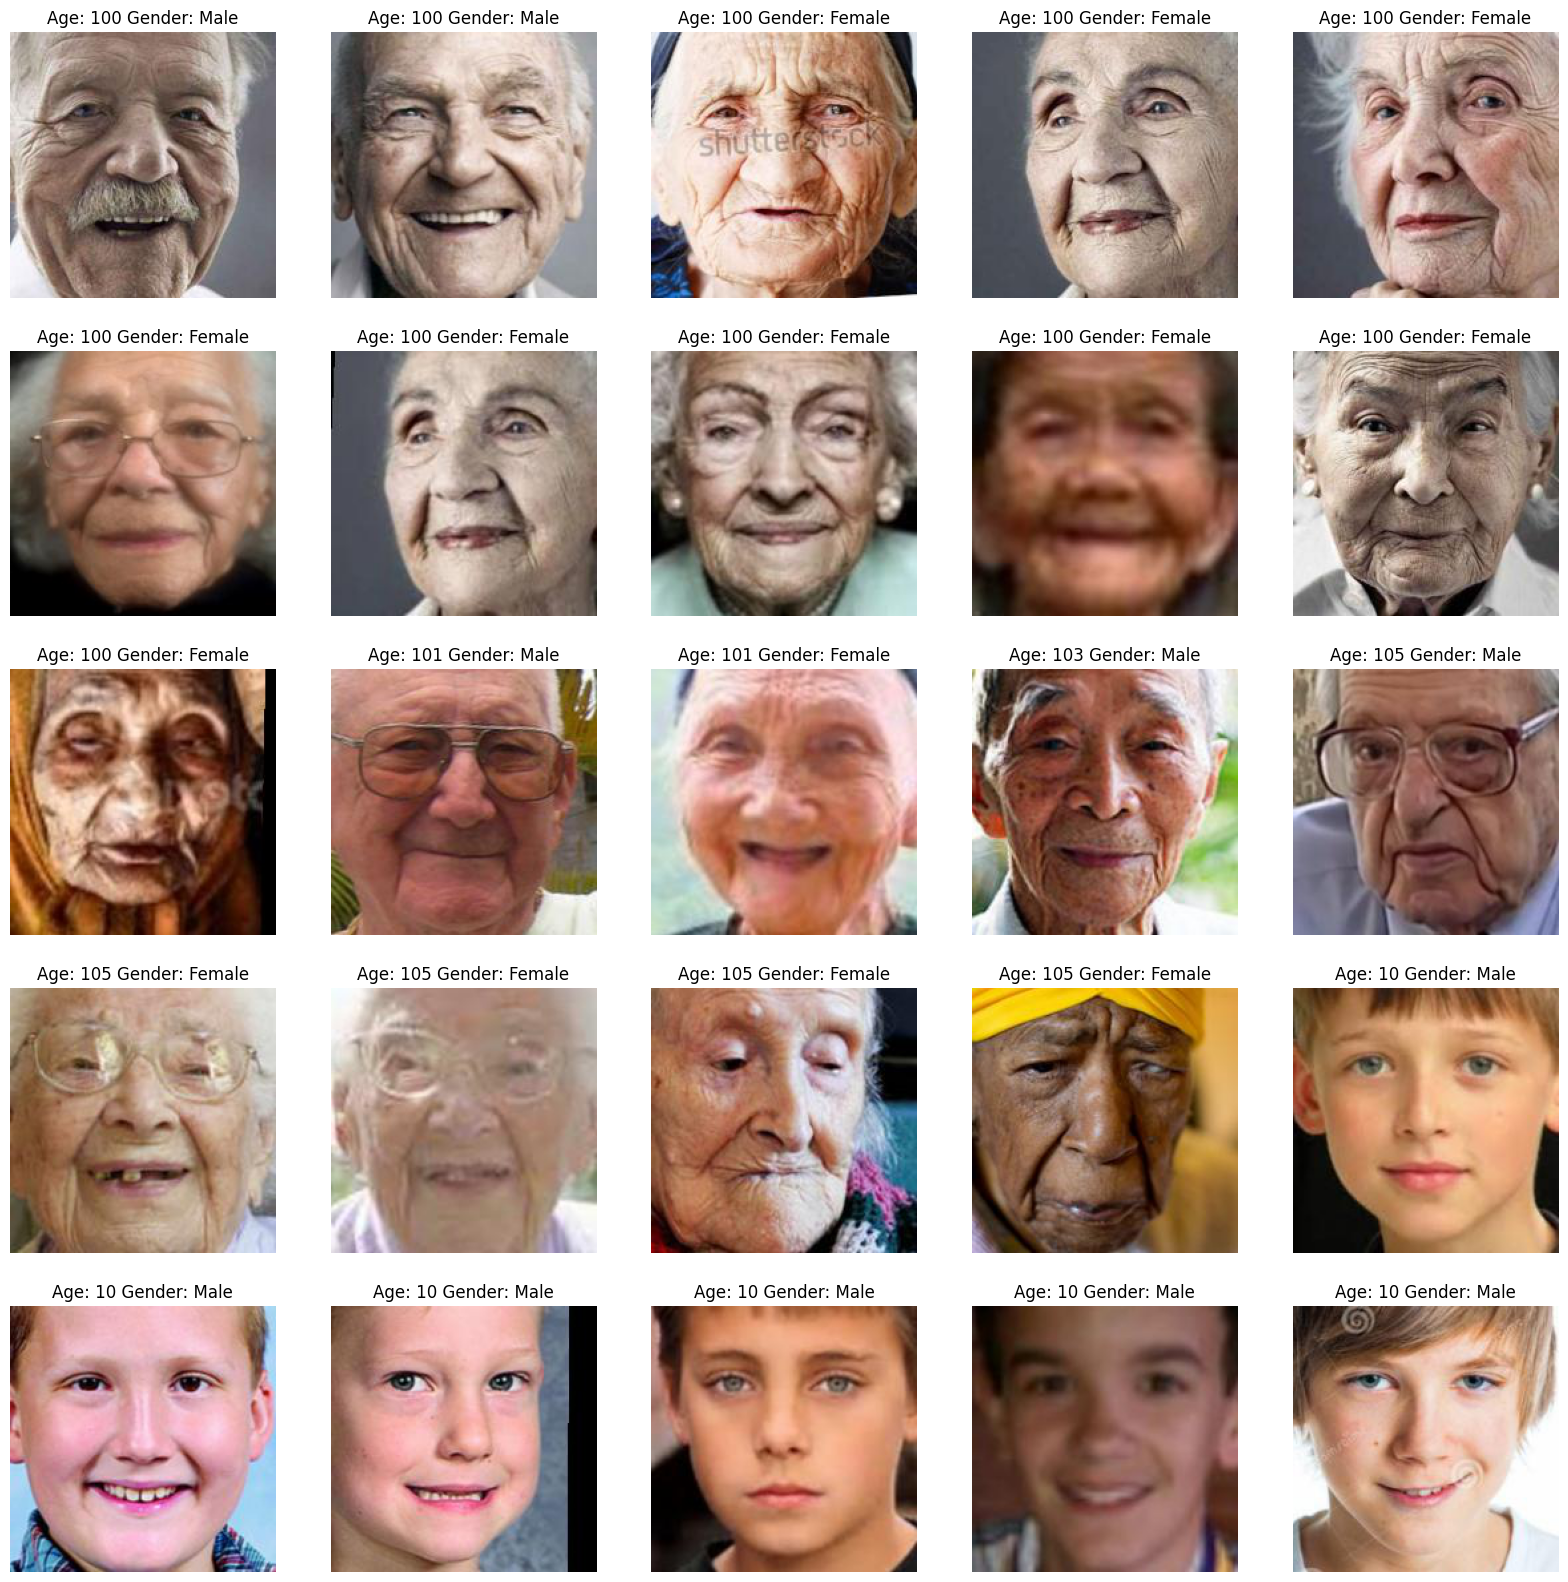

In [9]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [10]:
import PIL
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
    return np.array(features)



In [11]:
# Assuming df['image'] contains paths to images
X = extract_features(df['image'])

100%|██████████| 23708/23708 [01:04<00:00, 368.41it/s]


In [12]:
X.shape

(23708, 128, 128)

In [13]:
# normalize the images
X = X/255.0

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (128, 128, 1)

## Model Creation

In [16]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [17]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [18]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 188s 308ms/step - age_out_mae: 11.5606 - gender_out_accuracy: 0.5018 - loss: 12.2789 - val_age_out_mae: 34.6274 - val_gender_out_accuracy: 0.7149 - val_loss: 35.1939
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 190s 320ms/step - age_out_mae: 8.2856 - gender_out_accuracy: 0.7592 - loss: 8.7903 - val_age_out_mae: 29.3043 - val_gender_out_accuracy: 0.7685 - val_loss: 29.7967
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 174s 293ms/step - age_out_mae: 7.2267 - gender_out_accuracy: 0.8181 - loss: 7.6207 - val_age_out_mae: 27.7459 - val_gender_out_accuracy: 0.7836 - val_loss: 28.2072
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 181s 305ms/step - age_out_mae: 6.7754 - gender_out_accuracy: 0.8377 - loss: 7.1315 - val_age_out_mae: 26.5292 - val_gender_out_accuracy: 0.7857 - val_loss: 26.9898
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 180s 304ms/step - age_out_mae: 6.4446 - gender_out_accuracy: 0.8537 - loss: 6.7643 - val_age_out_mae: 25.7238 - val_gender_out_accuracy: 0.798

## Plot the Results

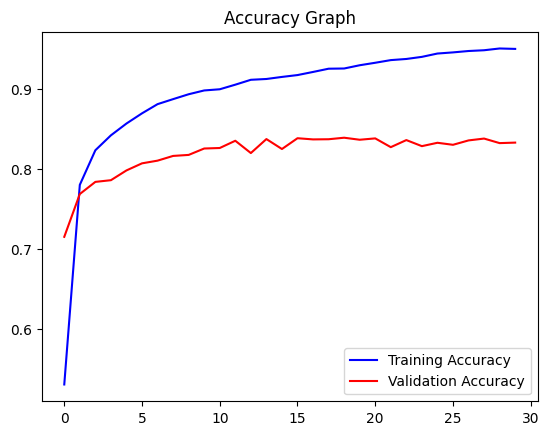

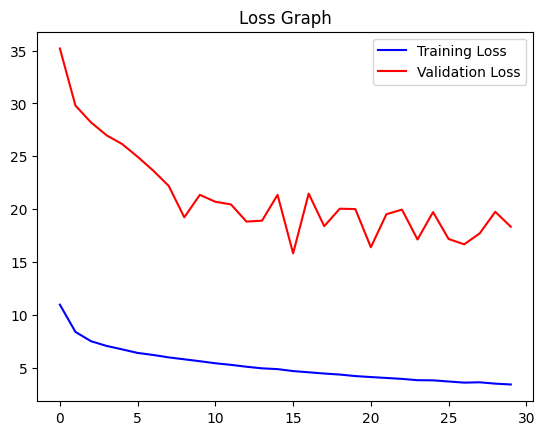

In [19]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

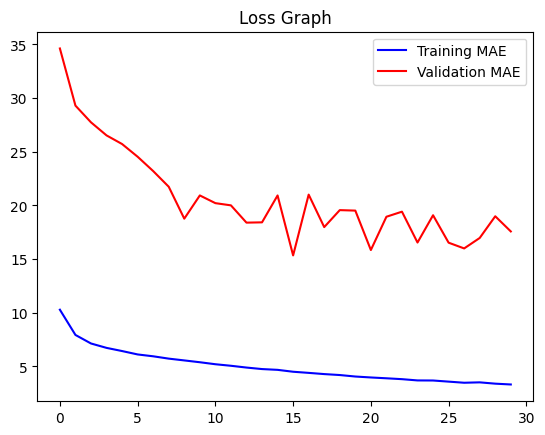

In [20]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Predicted Gender: Male Predicted Age: 14


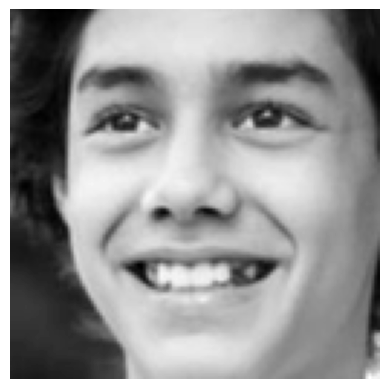

In [21]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Gender: Male Predicted Age: 25


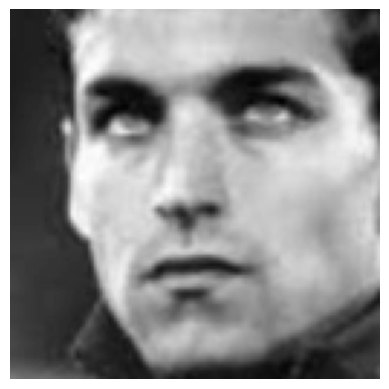

In [22]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 29


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Gender: Female Predicted Age: 36


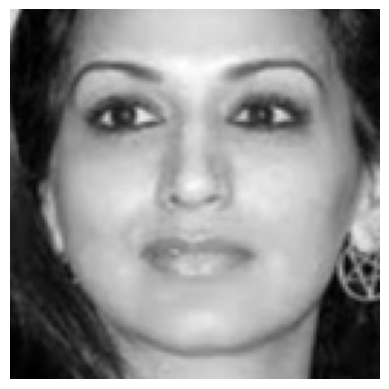

In [23]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [ ]:
# Function to predict and display results

def predict_and_display(image_index):

    print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

    pred = model.predict(X[image_index].reshape(1, 128, 128, 1))

    pred_gender = gender_dict[round(pred[0][0][0])]

    pred_age = round(pred[1][0][0])

    print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

    plt.axis('off')

    plt.imshow(X[image_index].reshape(128, 128), cmap='gray')

    plt.show()
    # Test predictions on sample images

predict_and_display(100)

predict_and_display(3000)

predict_and_display(10000)



Failed to open/load file: Unable to open file (file signature not found)
Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Gender: Male Predicted Age: 14


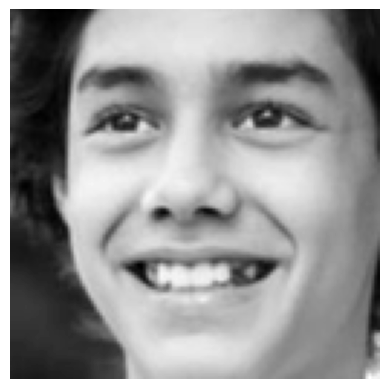

Original Gender: Male Original Age: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Gender: Male Predicted Age: 25


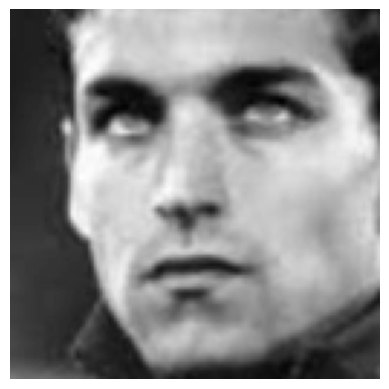

Original Gender: Female Original Age: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Gender: Female Predicted Age: 36


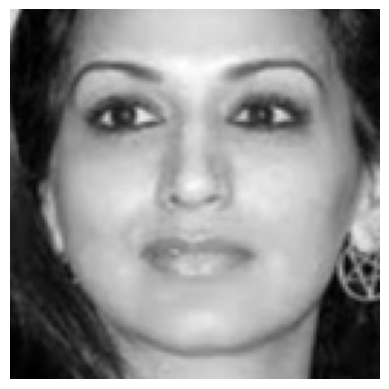

In [38]:

import os
from keras.models import load_model
import h5py

file_path = 'D:/GENDER_PREDICTION/age_gender_model.h5'

if os.path.exists(file_path):
    try:
        # Check if the file is a valid HDF5 file
        with h5py.File(file_path, 'r') as f:
            print("File content:")
            print(list(f.keys()))
        # Load the model
        model = load_model(file_path)
        print("Model loaded successfully.")
    except OSError as e:
        print(f"Failed to open/load file: {e}")
else:
    print(f"File not found: {file_path}")

# Predict using the loaded model
predict_and_display(100)
predict_and_display(3000)
predict_and_display(10000)